In [1]:
import os
import sys

spark_path = '/Users/pradmishra/Downloads/spark-2.4.0-bin-hadoop2.7'
os.environ['SPARK_HOME']= spark_path
os.environ['HADOOP_HOME']=spark_path
sys.path.append(spark_path+'/bin')
sys.path.append(spark_path+'/python')
sys.path.append(spark_path+'/python/pyspark')
sys.path.append(spark_path+'/python/lib')
sys.path.append(spark_path+'/python/lib/pyspark.zip')
sys.path.append(spark_path+'/python/lib/py4j-0.10.7-src.zip')

from pyspark import SparkContext
from pyspark import SparkConf

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('bank.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



# Input variables: age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome.
# Output variable: deposit


In [3]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas()

,summary,age,balance,day,duration,campaign,pdays,previous
0,count,11162,11162,11162,11162,11162,11162,11162
1,mean,41.231947679627304,1528.5385235620856,15.658036194230425,371.99381831213043,2.508421429851281,51.33040673714388,0.8325568894463358
2,stddev,11.913369192215518,3225.413325946149,8.420739541006462,347.12838571630687,2.7220771816614824,108.75828197197717,2.292007218670508
3,min,18,-6847,1,2,1,-1,0
4,max,95,81204,31,3881,63,854,58


In [5]:
#Correlations between independent variables.

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  


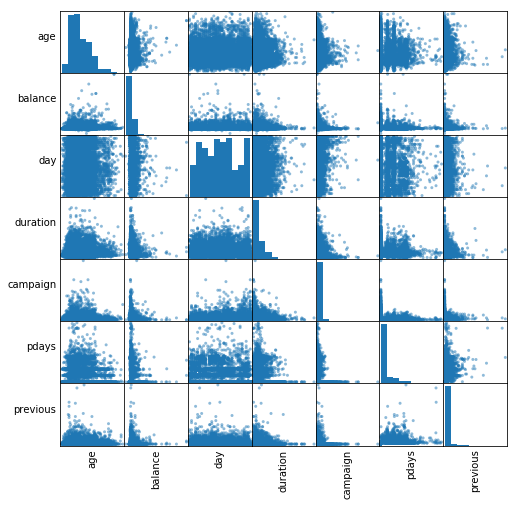

In [7]:
numeric_data = df.select(numeric_features).toPandas()
axs = pd.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [8]:
#It’s obvious that there aren’t highly correlated numeric variables. 
#Therefore, we will keep all of them for the model.

In [9]:
df = df.select('age', 'job', 'marital', 'education', 'default', 
               'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 
               'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



 # Preparing Data for Machine Learning
The process includes Category Indexing, One-Hot Encoding and VectorAssembler — a feature transformer that merges multiple columns into a vector column.

In [10]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], 
                                     outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

# Pipeline
We use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. A Pipeline’s stages are specified as an ordered array.

In [11]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [12]:
pd.DataFrame(df.take(5), columns=df.columns)

,label,features,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,deposit
0,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",59,admin.,married,secondary,no,2343,yes,no,unknown,1042,1,-1,0,unknown,yes
1,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",56,admin.,married,secondary,no,45,no,no,unknown,1467,1,-1,0,unknown,yes
2,1.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",41,technician,married,secondary,no,1270,yes,no,unknown,1389,1,-1,0,unknown,yes
3,1.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",55,services,married,secondary,no,2476,yes,no,unknown,579,1,-1,0,unknown,yes
4,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",54,admin.,married,tertiary,no,184,no,no,unknown,673,2,-1,0,unknown,yes


In [13]:
# Randomly split data into train and test sets, and set seed for reproducibility.

In [14]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))
                                   

Training Dataset Count: 7764
Test Dataset Count: 3398


In [15]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=100)
lrModel = lr.fit(train)

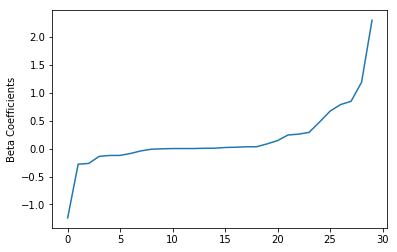

In [16]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [17]:
# Summarize the model over the training set, we can also obtain the receiver-operating characteristic and 
# areaUnderROC

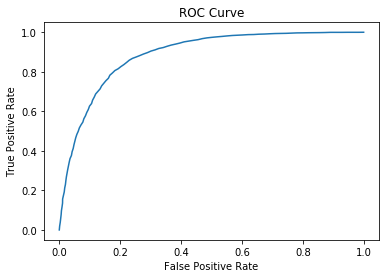

Training set areaUnderROC: 0.8863500294956214


In [18]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [19]:
# Precision and recall.

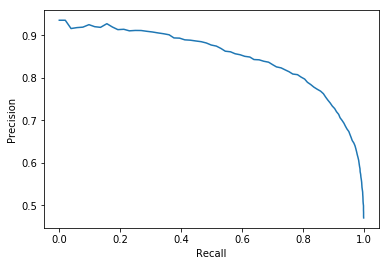

In [20]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [21]:
# Make predictions on the test set.

In [22]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 37|management|  0.0|[1.16500916492197...|       0.0|[0.76224171438334...|
| 40|management|  0.0|[2.11444738042022...|       0.0|[0.89229947775653...|
| 53|management|  0.0|[0.89139667963532...|       0.0|[0.70917831410064...|
| 32|management|  0.0|[1.25500691269156...|       0.0|[0.77816537822361...|
| 54|management|  0.0|[1.17165748343680...|       0.0|[0.76344448296564...|
| 40|management|  0.0|[1.67410117893459...|       0.0|[0.84212184909110...|
| 56|management|  0.0|[2.95969069802851...|       0.0|[0.95071950454226...|
| 50|management|  0.0|[-0.9166716270363...|       1.0|[0.28563655835278...|
| 47|management|  0.0|[0.69569986401943...|       0.0|[0.66723368811205...|
| 44|management|  0.0|[1.20889073998621...|       0.0|[0.77010261942216...|
+---+-------

In [23]:
# Evaluate our Logistic Regression model.

In [24]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8880439820275378


# Decision Tree Classifier
Decision trees are widely used since they are easy to interpret, handle categorical features, extend to the multi-class classification, do not require feature scaling, and are able to capture non-linearities and feature interactions.

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)


+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 37|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 40|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 53|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 32|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 54|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 40|management|  0.0|  [373.0,30.0]|       0.0|[0.92555831265508...|
| 56|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 50|management|  0.0|[788.0,1230.0]|       1.0|[0.39048562933597...|
| 47|management|  0.0|[788.0,1230.0]|       1.0|[0.39048562933597...|
| 44|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 10 

In [ ]:
# Evaluate our Decision Tree model.

In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7910083562522027


In [ ]:
# Random Forest Classifier

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 37|management|  0.0|[15.1048321548839...|       0.0|[0.75524160774419...|
| 40|management|  0.0|[15.1048321548839...|       0.0|[0.75524160774419...|
| 53|management|  0.0|[12.6020407354251...|       0.0|[0.63010203677125...|
| 32|management|  0.0|[15.1048321548839...|       0.0|[0.75524160774419...|
| 54|management|  0.0|[15.1488750939632...|       0.0|[0.75744375469816...|
| 40|management|  0.0|[15.1816198004196...|       0.0|[0.75908099002098...|
| 56|management|  0.0|[16.3832282413613...|       0.0|[0.81916141206806...|
| 50|management|  0.0|[5.37079252062007...|       1.0|[0.26853962603100...|
| 47|management|  0.0|[9.45062662573799...|       1.0|[0.47253133128689...|
| 44|management|  0.0|[10.3375367258555...|       0.0|[0.51687683629277...|
+---+-------

In [ ]:
# Evaluate our Random Forest Classifier.

In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8804849179499828


In [ ]:
# Gradient-Boosted Tree Classifier

In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 37|management|  0.0|[0.57808138910181...|       0.0|[0.76063477260811...|
| 40|management|  0.0|[1.37467582901950...|       0.0|[0.93987672346171...|
| 53|management|  0.0|[-0.0012929624008...|       1.0|[0.49935351915983...|
| 32|management|  0.0|[0.61900313605401...|       0.0|[0.77521678642033...|
| 54|management|  0.0|[0.98157815641818...|       0.0|[0.87687413211579...|
| 40|management|  0.0|[0.96138354833170...|       0.0|[0.87244668327834...|
| 56|management|  0.0|[1.39120025731353...|       0.0|[0.94171733839668...|
| 50|management|  0.0|[-0.6141629093446...|       1.0|[0.22647458093662...|
| 47|management|  0.0|[-0.0439971283470...|       1.0|[0.47801561939801...|
| 44|management|  0.0|[0.26452511568224...|       0.0|[0.62926156628314...|
+---+-------

In [ ]:
#Evaluate our Gradient-Boosted Tree Classifier.
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8940728473145346


In [ ]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6, 8, 10])
             .addGrid(gbt.maxBins, [20,40,60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 10 minutes since it is training over 30 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)